In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color
import numpy as np

import plotly.express as px


[LEGO Catalog Database Download](https://rebrickable.com/downloads/)

In [2]:
colors_df = pd.read_csv(r'colors.csv')
elements_df = pd.read_csv(r'elements.csv')
inventories_df = pd.read_csv(r'inventories.csv')
inventory_minifigs_df = pd.read_csv(r'inventory_minifigs.csv')
inventory_parts_df = pd.read_csv(r'inventory_parts.csv')
inventory_sets_df = pd.read_csv(r'inventory_sets.csv')
minifigs_df = pd.read_csv(r'minifigs.csv')
parts_df = pd.read_csv(r'parts.csv')
part_categories_df = pd.read_csv(r'part_categories.csv')
part_relationships_df = pd.read_csv(r'part_relationships.csv')
sets_df = pd.read_csv(r'sets.csv')
themes_df = pd.read_csv(r'themes.csv')

![Rebrickable ERD](https://rebrickable.com/static/img/diagrams/downloads_schema_v3.png)

In [3]:
colors_df.rename(columns={'id':'color_id','name':'color_name'}, inplace=True)
parts_df.rename(columns={'name':'part_name'}, inplace=True)

inventory_parts_colors = pd.merge(inventory_parts_df, colors_df,how='left', left_on='color_id', right_on='color_id')
inventories_sets = pd.merge(inventories_df, sets_df,how='left', left_on='set_num', right_on='set_num')
df = pd.merge(inventory_parts_colors, inventories_sets, how='left', left_on='inventory_id',right_on = 'id')

In [4]:
num_parts_overtime = df.groupby(["year",'set_num'])["num_parts"].mean()
avg_pieces_series = num_parts_overtime.groupby('year').mean()
avg_pieces_series = pd.DataFrame(avg_pieces_series).reset_index()


avg_unique_pieces_per_set = df.groupby(['year', 'set_num'])['part_num'].nunique().reset_index(name='unique_part_count')
avg_diff_pieces_series = avg_unique_pieces_per_set.groupby('year')['unique_part_count'].mean()
avg_diff_pieces_series = pd.DataFrame(avg_diff_pieces_series).reset_index()


diff_colors = df.groupby(['year', 'set_num'])['color_name'].nunique().reset_index(name='unique_color_count')
diff_colors_per_year = diff_colors.groupby('year')['unique_color_count'].mean()
diff_colors_per_year = pd.DataFrame(diff_colors_per_year).reset_index()


In [5]:
fig_avg_pieces = px.line(avg_pieces_series,x='year',y='num_parts',title= 'Average number of parts per set')
fig_avg_pieces.show()

In [6]:
fig_avg_diff_pieces_series = px.line(avg_diff_pieces_series,x='year',y='unique_part_count',title= 'Avg Number of different types of pieces per set')
fig_avg_diff_pieces_series.show()

In [7]:
fig_diff_colors_per_year = px.line(diff_colors_per_year,x='year',y='unique_color_count',title= 'Avg Number of different colors per set')
fig_diff_colors_per_year.show()

In [8]:
def min_max_normalize(series):
    """Apply Min-Max normalization to a pandas Series."""
    min_val = series.min()
    max_val = series.max()
    normalized_series = (series - min_val) / (max_val - min_val)
    return normalized_series

In [9]:
min_max_normalize(num_parts_overtime)

year    set_num
1949.0  700.1-1    0.012142
        700.2-1    0.015220
        700.3-1    0.012142
        700.A-1    0.002052
        700.B-1    0.001026
                     ...   
2024.0  21252-1    0.017358
        21253-1    0.017614
        71429-1    0.019667
        71430-1    0.019496
        76995-1    0.016759
Name: num_parts, Length: 16381, dtype: float64

In [10]:
# complexity should be number of parts, number of different parts, number of different colors, 

Normilizing data

Average Number of Pieces per Set (Pieces)

In [11]:

def min_max_normalize(series):
    """Apply Min-Max normalization to a pandas Series."""
    min_val = series.min()
    max_val = series.max()
    normalized_series = (series - min_val) / (max_val - min_val)
    return normalized_series

def normalize_lego_metrics(avg_pieces, avg_diff_pieces, avg_diff_colors):
    """Normalize LEGO metrics using Min-Max normalization."""
    normalized_avg_pieces = min_max_normalize(avg_pieces)
    normalized_avg_diff_pieces = min_max_normalize(avg_diff_pieces)
    normalized_avg_diff_colors = min_max_normalize(avg_diff_colors)
    
    return normalized_avg_pieces, normalized_avg_diff_pieces, normalized_avg_diff_colors

def calculate_complexity_index(normalized_avg_pieces, normalized_avg_diff_pieces, normalized_avg_diff_colors, weights):
    """Calculate complexity index using normalized metrics and user-defined weights."""
    complexity_index = (
        weights[0] * normalized_avg_pieces +
        weights[1] * normalized_avg_diff_pieces +
        weights[2] * normalized_avg_diff_colors
    )
    return complexity_index

normalized_avg_pieces, normalized_avg_diff_pieces, normalized_avg_diff_colors = normalize_lego_metrics(
    avg_pieces_series,
    avg_diff_pieces_series,
    diff_colors_per_year
)

user_weights = [1/3, 1/3, 1/3] 

complexity_index = calculate_complexity_index(
    normalized_avg_pieces,
    normalized_avg_diff_pieces,
    normalized_avg_diff_colors,
    user_weights
)


In [12]:
normalized_avg_diff_colors

,year,unique_color_count
0,0.000000,0.217329
1,0.013333,0.000000
2,0.053333,0.249023
3,0.066667,0.218299
4,0.080000,0.094670
...,...,...
69,0.946667,0.820939
70,0.960000,0.839587
71,0.973333,0.906668
72,0.986667,1.000000


<Axes: >

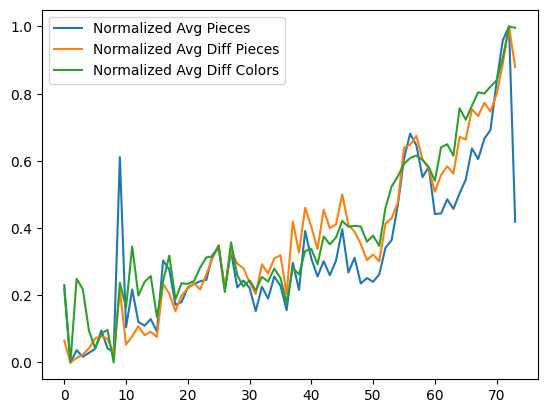

In [13]:
normalized_df = pd.concat([normalized_avg_pieces['num_parts'], normalized_avg_diff_pieces['unique_part_count'], normalized_avg_diff_colors['unique_color_count']], axis=1)
normalized_df.columns = ['Normalized Avg Pieces', 'Normalized Avg Diff Pieces', 'Normalized Avg Diff Colors']
normalized_df.plot()

In [17]:
import pandas as pd
import plotly.express as px

# Assuming normalized_avg_pieces, normalized_avg_diff_pieces, normalized_avg_diff_colors are DataFrames with the respective columns

# Combine the DataFrames
normalized_df = pd.concat([normalized_avg_pieces['num_parts'], normalized_avg_diff_pieces['unique_part_count'], normalized_avg_diff_colors['unique_color_count']], axis=1)
normalized_df.columns = ['Normalized Avg Pieces', 'Normalized Avg Diff Pieces', 'Normalized Avg Diff Colors']

# Create an interactive line plot using Plotly Express
fig = px.line(normalized_df, title='Normalized Averages Over Time')

# Show the plot
fig.show()

In [20]:
import pandas as pd
import plotly.express as px

# Assuming normalized_avg_pieces, normalized_avg_diff_pieces, normalized_avg_diff_colors are DataFrames with the respective columns

# Combine the DataFrames
normalized_df = pd.concat([normalized_avg_pieces['num_parts'], normalized_avg_diff_pieces['unique_part_count'], normalized_avg_diff_colors['unique_color_count']], axis=1)
normalized_df.columns = ['Normalized Avg Pieces', 'Normalized Avg Diff Pieces', 'Normalized Avg Diff Colors']

# Create an interactive line plot using Plotly Express
fig = px.line(normalized_df, title='Complexity Index', line_shape='linear')

# Rename the lines
fig.for_each_trace(lambda t: t.update(name=t.name.replace("Normalized Avg ", "")))

# Show the plot
fig.show()


In [21]:
fig.write_html("Complexity_Index.html")


<Axes: >

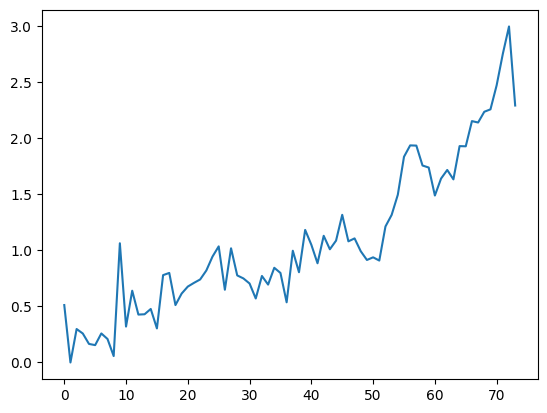

In [14]:

complexity_index = normalized_avg_pieces['num_parts']+ normalized_avg_diff_pieces['unique_part_count']+ normalized_avg_diff_colors['unique_color_count']
complexity_index.plot()